In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
import sympy as smp
from IPython.display import display as disp
import lablib as ll
%matplotlib inline
mp.rc("savefig", dpi=96)

Загружаем данные, приводим к СИ, считаем скорости шариков.

In [2]:
data, columns, experiments = ll.read_standard_layout()

# recalculate diameters in mm to m
for e in experiments:
    ll.compute(name = "d",
               expr = lambda d: d / 1000,
               data = data[e],
               columns = columns[e])
    
    ll.compute(name = "T",
               expr = lambda T: T + 273,
               data = data[e],
               columns = columns[e])
    
# compute velocities of the test spheres
for e in experiments:
    ll.compute(name = "v",
               expr = lambda L, t_10, t_20: L / (t_20 - t_10),
               data = data[e],
               columns = columns[e],
               aux = { "t_10": { "Error": "Error_t" },
                       "t_20": { "Error": "Error_t" }})
    del columns[e]["t_10"]
    del columns[e]["t_20"]
    del columns[e]["Error_t"]

Получаем зависимость плотности глицерина от температуры (у нас много разных температур, не для всех есть экспериментальные значения плотности).

In [3]:
# linear-fit the glycerin densities

# http://www.aciscience.org/docs/physical_properties_of_glycerine_and_its_solutions.pdf
gly_T = [ x + 273 for x in [20, 30, 40, 54, 75.5] ]
gly_de = [ x * 1000 for x in [1.26134, 1.25512, 1.24896, 1.2397, 1.2256] ]

gly_model = ll.fit2(name = "de_gly",
            model = lambda _T, _de_gly_k, _de_gly_l: _T * _de_gly_k + _de_gly_l,
            data = data["global"],
            x = gly_T,
            y = gly_de,
            xerr = [0.1 for x in gly_T],
            yerr = [0.00001 for x in gly_de])

for e in experiments:
    ll.add(data[e], data["global"].loc[["_de_gly_k", "_de_gly_l"]])

Initial guesses for de_gly:
                 Value    Error  ErrorRel
_de_gly_k   -0.645255 0.000000 -0.000000
_de_gly_l 1450.625233 0.000073  0.000000


'Final guesses for de_gly:'

,Value,Error,ErrorRel
_de_gly_k,-0.645395,0.005486,-0.85%
_de_gly_l,1450.669550,1.741745,0.12%


Считаем вязкость для каждого эксперимента. Оцениваем число Рейнольдса и время релаксации. Можно видеть, что условия применимости расчётных формул (ламинарность обтекания, установление скорости на момент начала замера) выполняются.

In [4]:
for e in experiments:
    ll.compute(name = "vi",
               expr = lambda d, de, T, _de_gly_k, _de_gly_l, v: 2/9 * ll.g * (d/2)**2 * (de - (T*_de_gly_k+_de_gly_l)) / v,
#               expr = lambda d, D, de, T, _de_gly_k, _de_gly_l, v: 2/9 * ll.g * (d/2)**2 * (de - (T*_de_gly_k+_de_gly_l)) / ((1 + 2.4*(d/D)) * v),
               data = data[e],
               columns = columns[e])
    
    ll.compute(name = "Re",
               expr = lambda d, v, vi, T, _de_gly_k, _de_gly_l: v * (d/2) * (T*_de_gly_k+_de_gly_l) / vi,
               data = data[e],
               columns = columns[e])
    
#    ll.compute(name = "t_relax",
#               expr = lambda d, de, vi: 2/9 * (d/2)**2 * de / vi,
#               data = data[e],
#               columns = columns[e])

for e in experiments:
    print("Experiment %s:" % e)
    disp(columns[e])

Experiment T=20:


,T,Error_T,ErrorRel_T,de,Error_de,ErrorRel_de,d,Error_d,ErrorRel_d,v,Error_v,ErrorRel_v,vi,Error_vi,ErrorRel_vi,Re,Error_Re,ErrorRel_Re
0,295.300000,0.050000,0.02%,2500,50,2.00%,0.002100,0.000050,2.38%,0.008000,0.000240,3.00%,0.372382,0.025792,6.93%,0.028424,0.002250,7.92%
1,295.700000,0.050000,0.02%,7800,50,0.64%,0.000550,0.000050,9.09%,0.002778,0.000039,1.40%,0.388030,0.070823,18.25%,0.002480,0.000507,20.44%
2,295.800000,0.050000,0.02%,7800,50,0.64%,0.000750,0.000050,6.67%,0.005263,0.000111,2.11%,0.380818,0.051492,13.52%,0.006529,0.000994,15.22%


Experiment T=30:


,T,Error_T,ErrorRel_T,de,Error_de,ErrorRel_de,d,Error_d,ErrorRel_d,v,Error_v,ErrorRel_v,vi,Error_vi,ErrorRel_vi,Re,Error_Re,ErrorRel_Re
0,306.100000,0.050000,0.02%,2500,50,2.00%,0.002050,0.000050,2.44%,0.015385,0.000851,5.53%,0.185565,0.015581,8.40%,0.106489,0.011019,10.35%
1,306.200000,0.050000,0.02%,7800,50,0.64%,0.000650,0.000050,7.69%,0.008333,0.000259,3.11%,0.180840,0.028418,15.71%,0.018766,0.003335,17.77%
2,306.200000,0.050000,0.02%,7800,50,0.64%,0.000700,0.000050,7.14%,0.009524,0.000335,3.51%,0.183515,0.027034,14.73%,0.022760,0.003811,16.75%


Experiment T=40:


,T,Error_T,ErrorRel_T,de,Error_de,ErrorRel_de,d,Error_d,ErrorRel_d,v,Error_v,ErrorRel_v,vi,Error_vi,ErrorRel_vi,Re,Error_Re,ErrorRel_Re
0,316.100000,0.050000,0.02%,2500,50,2.00%,0.001350,0.000050,3.70%,0.012500,0.000566,4.53%,0.099558,0.009516,9.56%,0.105654,0.011843,11.21%
1,316.100000,0.050000,0.02%,7800,50,0.64%,0.000700,0.000050,7.14%,0.016667,0.000996,5.98%,0.104968,0.016275,15.50%,0.069280,0.012531,18.09%


Experiment T=50:


,T,Error_T,ErrorRel_T,de,Error_de,ErrorRel_de,d,Error_d,ErrorRel_d,v,Error_v,ErrorRel_v,vi,Error_vi,ErrorRel_vi,Re,Error_Re,ErrorRel_Re
0,326.000000,0.050000,0.02%,2500,50,2.00%,0.002150,0.000050,2.33%,0.050000,0.008853,17.71%,0.063450,0.011886,18.73%,1.050661,0.271932,25.88%
1,326.000000,0.050000,0.02%,2500,50,2.00%,0.002100,0.000050,2.38%,0.050000,0.008853,17.71%,0.060533,0.011357,18.76%,1.075677,0.278677,25.91%
2,326.000000,0.050000,0.02%,7800,50,0.64%,0.000700,0.000050,7.14%,0.027778,0.002742,9.87%,0.063042,0.010958,17.38%,0.191271,0.040603,21.23%
3,326.000000,0.050000,0.02%,7800,50,0.64%,0.000650,0.000050,7.69%,0.023256,0.001926,8.28%,0.064928,0.011355,17.49%,0.144378,0.030067,20.83%


Experiment T=60:


,T,Error_T,ErrorRel_T,de,Error_de,ErrorRel_de,d,Error_d,ErrorRel_d,v,Error_v,ErrorRel_v,vi,Error_vi,ErrorRel_vi,Re,Error_Re,ErrorRel_Re
0,336.000000,0.050000,0.01%,2500,50,2.00%,0.001200,0.000050,4.17%,0.026667,0.002528,9.48%,0.037251,0.004927,13.23%,0.529947,0.089034,16.80%
1,336.000000,0.050000,0.01%,7800,50,0.64%,0.000700,0.000050,7.14%,0.045455,0.007319,16.10%,0.038564,0.008306,21.54%,0.508998,0.141631,27.83%


Построим графики разброса вязкости от температуры. К каждой точке добавлено искажение температуры в пределах $[-0.01; +0.01]$, чтобы графики легче читались.

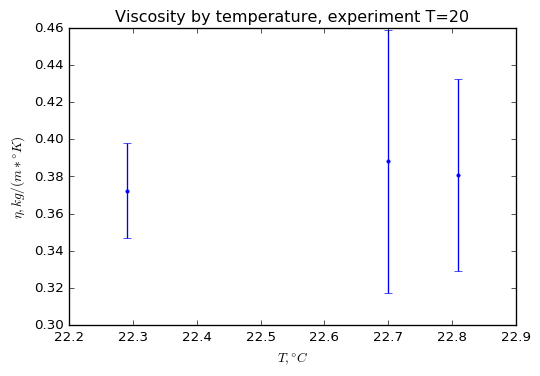

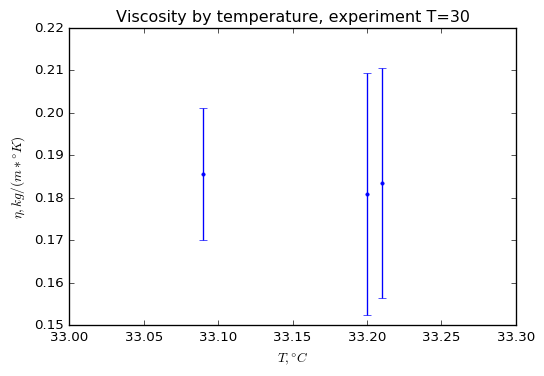

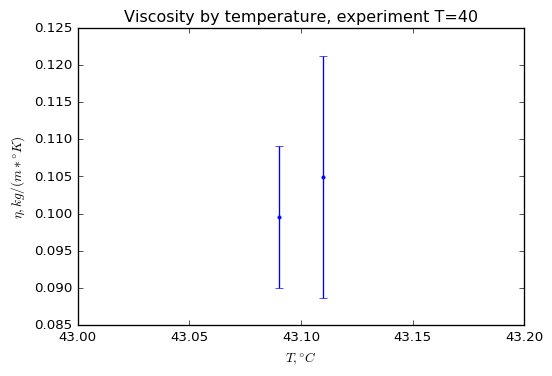

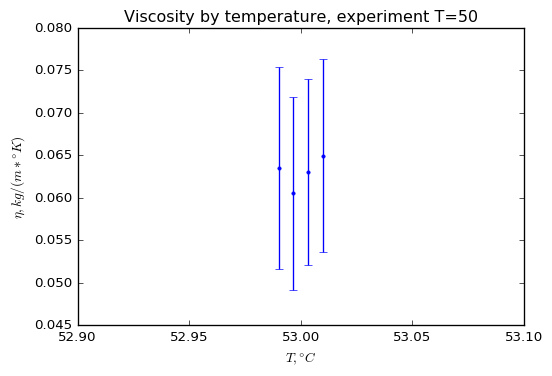

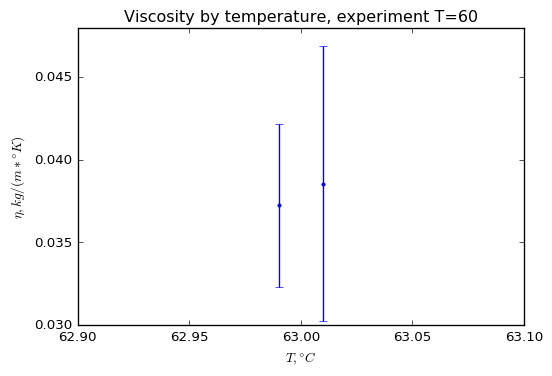

In [5]:
for i, e in enumerate(experiments):
    plt.title("Viscosity by temperature, experiment %s" % e)

    plt.xlabel("$T, \\degree C$")
    plt.ylabel("$\eta, kg/(m*\\degree K)$")

    T = columns[e]["T"]
    
    plt.errorbar(x = T - 273 + np.linspace(-0.01, 0.01, len(T)),
                 y = columns[e]["vi"],
                 yerr = columns[e]["Error_vi"],
                 label = e,
                 marker = ".",
                 markersize = 5,
                 linestyle = "none")
    plt.axis([min(T) - 273 - 0.1, max(T) - 273 + 0.1, None, None])
    plt.plot()
    plt.show()

Теперь соберём все экспериментальные точки на одном графике $\eta(T)$, приблизим теоретической зависимостью $\eta = A * e^{\frac{W}{kT}}$ и найдём отсюда $\frac{W}{k}$ (из-за проблем с точностью не можем найти сразу $W$).

'Final guesses for vi:'

,Value,Error,ErrorRel
W_k,5652.513162,75.607496,1.34%
_ln_A,-20.133991,0.244745,-1.22%


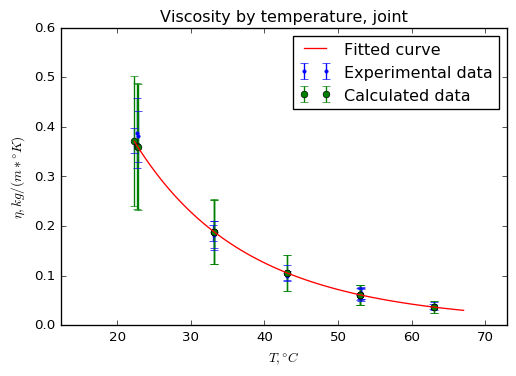

In [9]:
columns_all = pd.concat(columns.values(), ignore_index = True)

ll.compute(name = "ln_vi",
           expr = lambda vi: ll.log(vi),
           data = data["global"],
           columns = columns_all)

ll.compute(name = "_1_T",
           expr = lambda T: 1/T,
           data = data["global"],
           columns = columns_all)

model = ll.fit2(name = "vi",
                model = lambda T, W_k, _ln_A: ll.exp(_ln_A + W_k/T),
                x = columns_all["T"],
                xerr = columns_all["Error_T"],
                y = columns_all["vi"],
                yerr = columns_all["Error_vi"],
                data = data["global"],
                initial = [1, 1])

ll.compute(name = "vi_c",
           expr = lambda T, W_k, _ln_A: ll.exp(_ln_A + W_k/T),
           data = data["global"],
           columns = columns_all)

plt.title("Viscosity by temperature, joint")

plt.xlabel("$T, \\degree C$")
plt.ylabel("$\eta, kg/(m*\\degree K)$")

T = columns_all["T"]
T_linspace = ll.linspace(T)

plt.errorbar(x = T - 273 + np.linspace(-0.1, 0.1, len(T)),
             y = columns_all["vi"],
             yerr = columns_all["Error_vi"],
             marker = ".",
             markersize = 5,
             elinewidth = 1,
             linestyle = "none",
             label = "Experimental data")
plt.errorbar(x = T - 273,
             y = columns_all["vi_c"],
             yerr = columns_all["Error_vi_c"],
             marker = "o",
             markersize = 5,
             linestyle = "none",
             label = "Calculated data")
plt.plot(T_linspace - 273, model(T_linspace),
         label = "Fitted curve")

plt.axis([min(T) - 273 - 10, max(T) - 273 + 10, None, None])
plt.legend(loc = "best")

Наконец, найдём $W$.

In [7]:
ll.compute(name = "W",
           expr = lambda W_k: W_k * ll.k,
           data = data["global"])
pd.set_option("float_format", "{:e}".format)
disp(data["global"].loc[["W"]])
pd.set_option("float_format", "{:f}".format)

,Value,Error,ErrorRel
W,7.804134e-20,1.043874e-21,1.337591e-02
